# Transfer learning and fine tuning for image classification

## Transfer learning

### Importing the libraries

In [ ]:
import tensorflow as tf
import seaborn as sns
import zipfile
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
tf.__version__

'2.17.1'

### Loading the images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Computer Vision Masterclass/Datasets/homer_bart_2.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

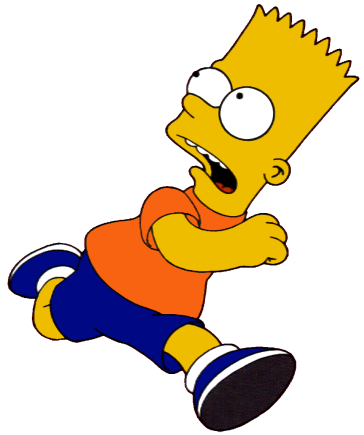

In [ ]:
tf.keras.preprocessing.image.load_img('/content/homer_bart_2/training_set/bart/bart100.bmp')

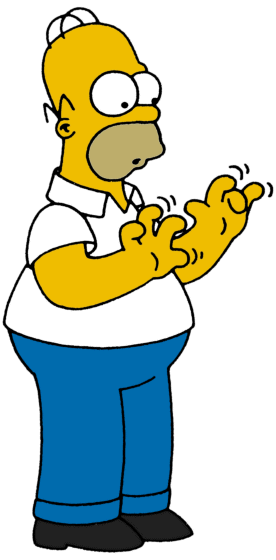

In [ ]:
tf.keras.preprocessing.image.load_img('/content/homer_bart_2/training_set/homer/homer100.bmp')

### Train and test set

In [ ]:
training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)
train_dataset = training_generator.flow_from_directory('/content/homer_bart_2/training_set',
                                                        target_size = (256, 256),
                                                        batch_size = 8,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

Found 215 images belonging to 2 classes.


In [ ]:
train_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
train_dataset.class_indices

{'bart': 0, 'homer': 1}

In [ ]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('/content/homer_bart_2/test_set',
                                                     target_size = (256, 256),
                                                     batch_size = 1,
                                                     class_mode = 'categorical',
                                                     shuffle = False)

Found 54 images belonging to 2 classes.


### Pre-trained network

- ResNet: https://arxiv.org/pdf/1512.03385.pdf
- Documentation: https://keras.io/api/applications/

In [ ]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,
                                            input_tensor = Input(shape = (256, 256, 3)))

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
len(base_model.layers)

175

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
for layer in base_model.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f01600aeda0> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f016001fc50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0172696e10> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f010b1423c8> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f0171d43a90> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f01600d1f60> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f0171d43c88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f01601c6240> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f010b142c18> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f010b1dbe48> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f016018e0b8> False
<tensorflow.python.keras.laye

### Custom dense layer

In [ ]:
base_model.output

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [ ]:
# Dropout: https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(units = 1025, activation='relu')(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(units = 1025, activation='relu')(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(2, activation='softmax')(head_model)

### Building and training the neural network

In [ ]:
base_model.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_3')>

In [ ]:
network = Model(inputs = base_model.input, outputs = head_model)

In [ ]:
8 * 8 * 2048

131072

In [ ]:
(2048 + 2) / 2

1025.0

In [ ]:
network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
network.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = network.fit(train_dataset, epochs=50)

Epoch 1/50
27/27 [==============================] - 3s 125ms/step - loss: 1.0317 - accuracy: 0.5721
Epoch 2/50
27/27 [==============================] - 3s 115ms/step - loss: 0.7064 - accuracy: 0.6093
Epoch 3/50
27/27 [==============================] - 3s 118ms/step - loss: 0.6811 - accuracy: 0.6093
Epoch 4/50
27/27 [==============================] - 3s 117ms/step - loss: 0.6296 - accuracy: 0.6372
Epoch 5/50
27/27 [==============================] - 3s 117ms/step - loss: 0.6385 - accuracy: 0.6186
Epoch 6/50
27/27 [==============================] - 3s 118ms/step - loss: 0.6039 - accuracy: 0.6279
Epoch 7/50
27/27 [==============================] - 3s 118ms/step - loss: 0.5711 - accuracy: 0.7209
Epoch 8/50
27/27 [==============================] - 3s 118ms/step - loss: 0.5847 - accuracy: 0.7256
Epoch 9/50
27/27 [==============================] - 3s 117ms/step - loss: 0.5222 - accuracy: 0.7349
Epoch 10/50
27/27 [==============================] - 3s 120ms/step - loss: 0.5613 - accuracy: 0.7209

### Evaluating the neural network

In [ ]:
test_dataset.class_indices

{'bart': 0, 'homer': 1}

In [ ]:
predictions = network.predict(test_dataset)
predictions

array([[7.13909388e-01, 2.86090642e-01],
       [5.47394753e-01, 4.52605277e-01],
       [1.17303483e-01, 8.82696569e-01],
       [7.60161281e-01, 2.39838719e-01],
       [7.75441706e-01, 2.24558339e-01],
       [7.31969655e-01, 2.68030375e-01],
       [6.33034017e-03, 9.93669689e-01],
       [4.80157554e-01, 5.19842446e-01],
       [3.45762014e-01, 6.54237986e-01],
       [5.00669479e-01, 4.99330491e-01],
       [1.67288899e-01, 8.32711160e-01],
       [8.77041936e-01, 1.22958042e-01],
       [6.93125010e-01, 3.06874961e-01],
       [4.67259616e-01, 5.32740414e-01],
       [5.77426553e-01, 4.22573417e-01],
       [8.54654014e-01, 1.45345956e-01],
       [2.14656025e-01, 7.85344005e-01],
       [4.22205001e-01, 5.77794969e-01],
       [8.05320263e-01, 1.94679707e-01],
       [7.17571497e-01, 2.82428503e-01],
       [3.53979051e-01, 6.46020949e-01],
       [7.26209760e-01, 2.73790240e-01],
       [9.97533441e-01, 2.46658060e-03],
       [6.16538942e-01, 3.83460999e-01],
       [7.623652

In [ ]:
predictions = np.argmax(predictions, axis = 1)
predictions

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
# Approach 1 (all pixels): 0.68
# Approach 2 (features): 0.88
# Approach 3 (CNN): 0.92
# Approach 4 (Transfer learning): 0.81
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)

0.8148148148148148

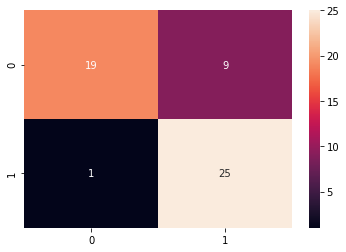

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(cm, annot=True);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.95      0.68      0.79        28
           1       0.74      0.96      0.83        26

    accuracy                           0.81        54
   macro avg       0.84      0.82      0.81        54
weighted avg       0.85      0.81      0.81        54



## Fine tuning

### Implementing

In [ ]:
base_model.trainable = True

In [ ]:
for layer in base_model.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f01600aeda0> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f016001fc50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0172696e10> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f010b1423c8> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f0171d43a90> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f01600d1f60> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f0171d43c88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f01601c6240> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f010b142c18> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f010b1dbe48> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f016018e0b8> False
<tensorflow.python.keras.laye

In [ ]:
len(base_model.layers)

175

In [ ]:
fine_tuning_at = 140

In [ ]:
for layer in base_model.layers[:fine_tuning_at]:
  layer.trainable = False

In [ ]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = network.fit(train_dataset, epochs=50)

Epoch 1/50
27/27 [==============================] - 7s 124ms/step - loss: 4.7051 - accuracy: 0.5535
Epoch 2/50
27/27 [==============================] - 3s 122ms/step - loss: 0.6776 - accuracy: 0.6092
Epoch 3/50
27/27 [==============================] - 3s 124ms/step - loss: 0.6045 - accuracy: 0.6571
Epoch 4/50
27/27 [==============================] - 3s 124ms/step - loss: 0.6580 - accuracy: 0.5946
Epoch 5/50
27/27 [==============================] - 3s 124ms/step - loss: 0.6364 - accuracy: 0.6268
Epoch 6/50
27/27 [==============================] - 3s 124ms/step - loss: 0.5240 - accuracy: 0.7559
Epoch 7/50
27/27 [==============================] - 3s 124ms/step - loss: 0.4338 - accuracy: 0.8068
Epoch 8/50
27/27 [==============================] - 3s 123ms/step - loss: 0.4635 - accuracy: 0.7278
Epoch 9/50
27/27 [==============================] - 3s 125ms/step - loss: 0.4829 - accuracy: 0.7699
Epoch 10/50
27/27 [==============================] - 3s 125ms/step - loss: 0.3660 - accuracy: 0.8429

### Evaluate

In [ ]:
predictions = network.predict(test_dataset)
predictions

array([[9.72169876e-01, 2.78300829e-02],
       [9.99957442e-01, 4.25853286e-05],
       [2.88479874e-04, 9.99711454e-01],
       [9.99982953e-01, 1.70481107e-05],
       [8.00148249e-01, 1.99851722e-01],
       [8.63243818e-01, 1.36756226e-01],
       [5.57753607e-04, 9.99442279e-01],
       [6.22878134e-01, 3.77121866e-01],
       [3.27191561e-01, 6.72808468e-01],
       [1.47802532e-01, 8.52197528e-01],
       [7.52783241e-03, 9.92472172e-01],
       [9.38886464e-01, 6.11135364e-02],
       [9.95265484e-01, 4.73458041e-03],
       [1.22921336e-02, 9.87707913e-01],
       [2.95890629e-01, 7.04109311e-01],
       [9.44802642e-01, 5.51973321e-02],
       [7.03953862e-01, 2.96046108e-01],
       [9.08595085e-01, 9.14048702e-02],
       [9.99794185e-01, 2.05883698e-04],
       [9.98276830e-01, 1.72318297e-03],
       [2.07068194e-02, 9.79293227e-01],
       [9.45850194e-01, 5.41498661e-02],
       [8.50578547e-01, 1.49421439e-01],
       [8.03454578e-01, 1.96545407e-01],
       [9.999024

In [ ]:
predictions = np.argmax(predictions, axis = 1)
predictions

array([0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
# Approach 1 (all pixels): 0.68
# Approach 2 (features): 0.88
# Approach 3 (CNN): 0.92
# Approach 4 (Transfer learning): 0.81
# Approach 4 (Fine tuning): 0.85
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)

0.8518518518518519

## Saving and loading the model

In [ ]:
model_json = network.to_json()
with open('network.json','w') as json_file:
  json_file.write(model_json)

In [ ]:
from keras.models import save_model
network_saved = save_model(network, '/content/weights.hdf5')

In [ ]:
with open('network.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Functional", "config": {"name": "model", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 256, 256, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_3"}, "name": "input_3", "inbound_nodes": []}, {"class_name": "ZeroPadding2D", "config": {"name": "conv1_pad", "trainable": false, "dtype": "float32", "padding": [[3, 3], [3, 3]], "data_format": "channels_last"}, "name": "conv1_pad", "inbound_nodes": [[["input_3", 0, 0, {}]]]}, {"class_name": "Conv2D", "config": {"name": "conv1_conv", "trainable": false, "dtype": "float32", "filters": 64, "kernel_size": [7, 7], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer

In [ ]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('weights.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
network_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Classifying one single image

In [ ]:
image = cv2.imread('/content/homer_bart_2/test_set/homer/homer15.bmp')

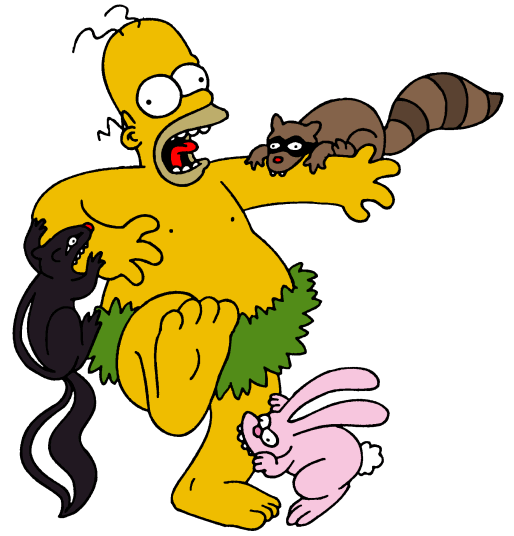

In [ ]:
cv2_imshow(image)

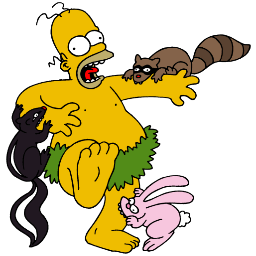

In [ ]:
image = cv2.resize(image, (256, 256))
cv2_imshow(image)

In [ ]:
image

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [ ]:
image = image / 255
image

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

In [ ]:
image.shape

(256, 256, 3)

In [ ]:
image = image.reshape(-1, 256, 256, 3)
image.shape

(1, 256, 256, 3)

In [ ]:
result = network_loaded(image)
result

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.00495395, 0.995046  ]], dtype=float32)>

In [ ]:
result = np.argmax(result)
result

1

In [ ]:
test_dataset.class_indices

{'bart': 0, 'homer': 1}

In [ ]:
if result == 0:
  print('Bart')
else:
  print('Homer')

Homer
